In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, BatchNormalization, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define paths to your dataset
train_dir = '/Users/giripragada/Downloads/chest_xray/train'
test_dir = '/Users/giripragada/Downloads/chest_xray/test'
val_dir = '/Users/giripragada/Downloads/chest_xray/val'



In [3]:
# Image dimensions
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

# Function to load and preprocess images
def load_and_preprocess_images(data_dir, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    data = []
    labels = []

    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)
        if os.path.isdir(label_path):
            label = 0 if label_dir == 'NORMAL' else 1  # 0: Normal, 1: Pneumonia
            
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
                
                if img is not None:
                    img_resized = cv2.resize(img, target_size)
                    data.append(img_resized)
                    labels.append(label)

    data = np.array(data, dtype=np.float32) / 255.0  # Normalize pixel values
    labels = np.array(labels)

    return data, labels


In [5]:

# Load datasets
x_train, y_train = load_and_preprocess_images(train_dir)
x_test, y_test = load_and_preprocess_images(test_dir)
x_val, y_val = load_and_preprocess_images(val_dir)

# Reshape data for deep learning
x_train = x_train.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
x_test = x_test.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
x_val = x_val.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(x_train)



In [7]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    BatchNormalization(),
    MaxPool2D((2, 2), strides=2, padding='same'),
    Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'),
    Dropout(0.1),
    BatchNormalization(),
    MaxPool2D((2, 2), strides=2, padding='same'),
    Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D((2, 2), strides=2, padding='same'),
    Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPool2D((2, 2), strides=2, padding='same'),
    Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPool2D((2, 2), strides=2, padding='same'),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dropout(0.2),
    Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])
model.summary()



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [9]:
# Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
    epochs=12,
    validation_data=(x_val, y_val),
    callbacks=[learning_rate_reduction, early_stopping]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")



Epoch 1/12


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 60s 361ms/step - accuracy: 0.7972 - loss: 1.5832 - val_accuracy: 0.5000 - val_loss: 15.3224 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 378ms/step - accuracy: 0.8917 - loss: 0.2808 - val_accuracy: 0.5000 - val_loss: 24.0382 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 419ms/step - accuracy: 0.9216 - loss: 0.2113 - val_accuracy: 0.6250 - val_loss: 2.3170 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 514ms/step - accuracy: 0.9187 - loss: 0.2292 - val_accuracy: 0.5000 - val_loss: 18.2272 - learning_rate: 0.0010
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.9258 - loss: 0.1991
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 535ms/step - accuracy: 0.9259 - loss: 0.1989 - val_accuracy: 0.5000 - val_loss: 0.9536 - learning_rate: 0.0010
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 512ms/step - accuracy: 0.9476 - loss

In [11]:
# Predictions
predictions = (model.predict(x_test) > 0.5).astype("int32")

# Classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))



20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       234
           1       0.94      0.94      0.94       390

    accuracy                           0.92       624
   macro avg       0.91      0.91      0.91       624
weighted avg       0.92      0.92      0.92       624

Confusion Matrix:
[[209  25]
 [ 25 365]]


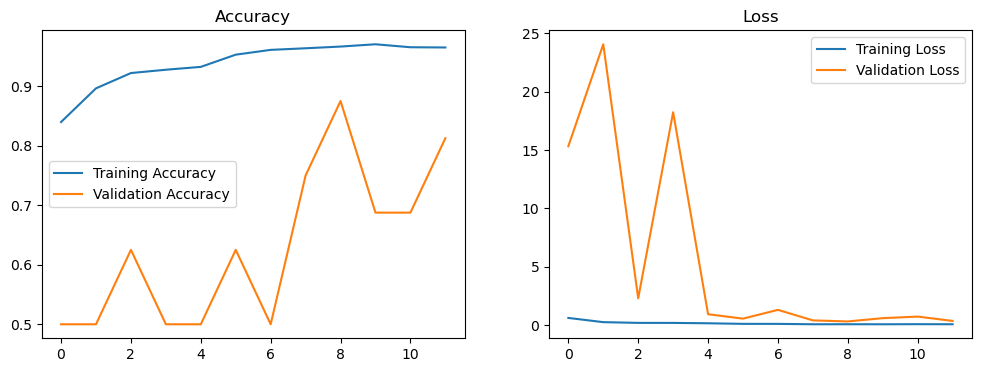

In [13]:
# Plotting training and validation metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


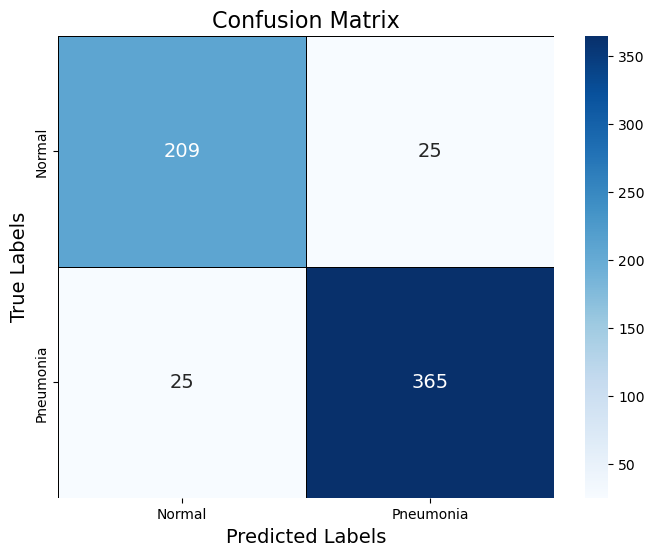

In [15]:
import seaborn as sns
import pandas as pd

# Create the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=['Normal', 'Pneumonia'], columns=['Normal', 'Pneumonia'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='black', annot_kws={"size": 14})
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()
